#  Predição de Preços de Carros usando Regressão Linear
# 
###  Este modelo implementa um modelo de Regressão Linear para prever preços de carros.

### 1. Importação das Bibliotecas


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import category_encoders as ce

### 2. Funções Auxiliares

In [7]:
def knn_input(df, n_neighbors=5):   
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

def remove_outliers_iqr(df, column):   
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1   
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR    
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

### 3. Carregamento e Pré-processamento dos Dados

In [8]:
train_path = '../data/raw/train.csv'
df = pd.read_csv(train_path)
df.drop(axis=1, columns=['id'], inplace=True)

In [9]:
df_input = knn_input(df, n_neighbors=25)

# Calcular a idade do carro
df_input['car_age'] = 2024 - df_input['model_year']
df_input = df_input.drop(columns=['model_year'], errors='ignore')

# Criar features compostas
df_input['engine_transmission'] = df_input['engine'].astype(str) + "_" + df_input['transmission'].astype(str)
df_input['int_ext_color'] = df_input['int_col'].astype(str) + "_" + df_input['ext_col'].astype(str)

# Remover colunas originais usadas nas features compostas
df_input.drop(columns=['engine', 'transmission', 'int_col', 'ext_col'], inplace=True, errors='ignore')

# Remover a coluna 'clean_title' se existir
if 'clean_title' in df_input.columns:
    df_input.drop(columns=['clean_title'], inplace=True)

In [10]:
# Identificar colunas categóricas
cat_cols_train = df_input.select_dtypes(include=['object']).columns.tolist()

# Inicializar o TargetEncoder
target_encoder = ce.TargetEncoder(cols=cat_cols_train)

# Separar features e target
X = df_input.drop(columns=['price', 'id'], errors='ignore')  # Remover 'price' e 'id' se existirem
y = df_input['price']

# Aplicar o TargetEncoder
X[cat_cols_train] = target_encoder.fit_transform(X[cat_cols_train], y)

# # Salvar o encoder
# encoder_path = '../models/target_encoder.pkl'
# joblib.dump(target_encoder, encoder_path)

In [11]:
# Remover outliers
df_train_no_outliers = remove_outliers_iqr(X.assign(price=y), 'milage')
df_train_no_outliers = remove_outliers_iqr(df_train_no_outliers, 'price')
df_train_no_outliers.reset_index(drop=True, inplace=True)

# Atualizar X e y após remoção de outliers
X = df_train_no_outliers.drop(columns=['price'], errors='ignore')
y = df_train_no_outliers['price']  # Correção: usar df_train_no_outliers['price']

### 4. Preparação para Modelagem

In [12]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [13]:
scaler = StandardScaler()
X_train.loc[:, ['brand','model', 'milage', 'int_ext_color', 'engine_transmission']] = scaler.fit_transform(X_train.loc[:, ['brand','model', 'milage', 'int_ext_color', 'engine_transmission']] )
X_test.loc[:, ['brand','model', 'milage', 'int_ext_color', 'engine_transmission']]  = scaler.transform(X_test.loc[:, ['brand','model', 'milage', 'int_ext_color', 'engine_transmission']] )

### 5. Treinamento e Avaliação do Modelo

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### 6. Métricas

In [15]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')

RMSE: 14133.07
R²: 0.56


### 7. Análise dos coeficientes

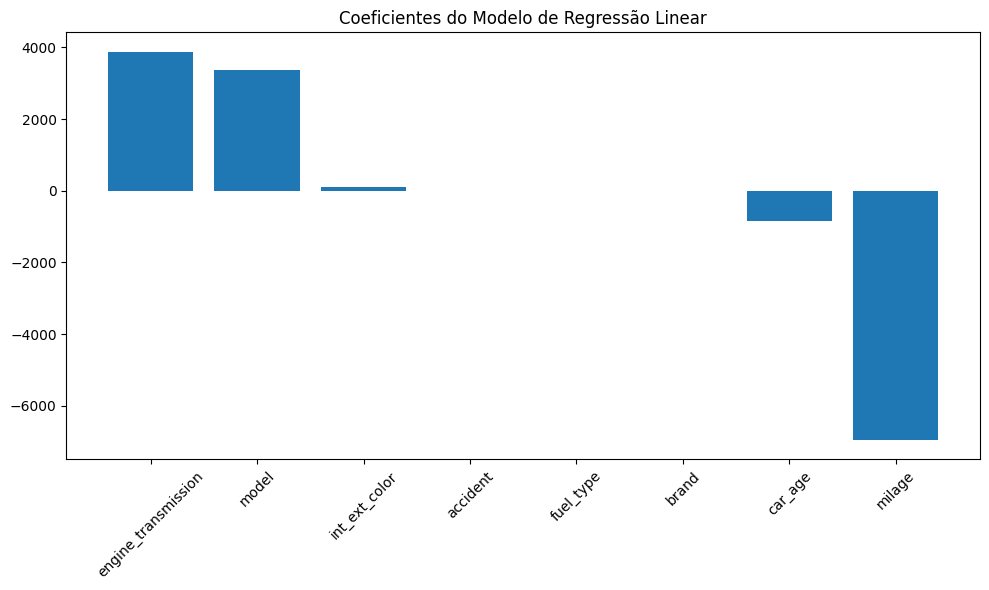

In [16]:
coef_df = pd.DataFrame({
'Feature': X.columns,
'Coefficient': model.coef_
})
coef_df = coef_df.sort_values('Coefficient', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(coef_df['Feature'], coef_df['Coefficient'])
plt.xticks(rotation=45)
plt.title('Coeficientes do Modelo de Regressão Linear')
plt.tight_layout()
plt.show()

### 8. Análise de Resíduos

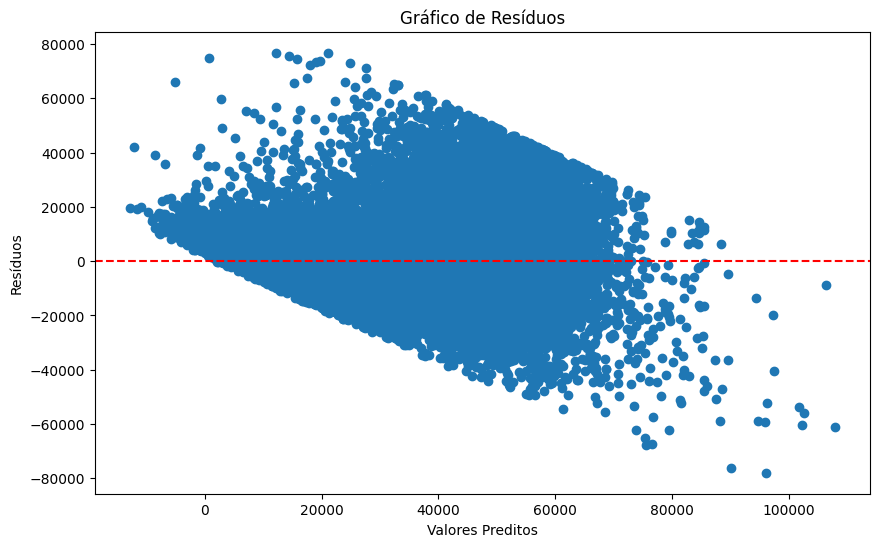

In [17]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos')
plt.show()